<a href="https://colab.research.google.com/github/saiful-kelubas-code/202055202063-Saiful/blob/master/3JenisMobil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download saifulkelubas/dataset-tiga-jenis-mobil
!mkdir mobil


dataset-tiga-jenis-mobil.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘mobil’: File exists


In [5]:
!unzip //content/dataset-tiga-jenis-mobil.zip -d /content/mobil

Archive:  //content/dataset-tiga-jenis-mobil.zip
  inflating: /content/mobil/Daihatsu Ayla/00a87b4e-a9f5.jpg  
  inflating: /content/mobil/Daihatsu Ayla/06adaf98-087b.jpg  
  inflating: /content/mobil/Daihatsu Ayla/0e2444f1-7f06.jpg  
  inflating: /content/mobil/Daihatsu Ayla/10e037c7-e678.jpg  
  inflating: /content/mobil/Daihatsu Ayla/12eb7cc4-9565.jpg  
  inflating: /content/mobil/Daihatsu Ayla/20221101085203-7b95.jpeg  
  inflating: /content/mobil/Daihatsu Ayla/20221101085204-f9e6.jpeg  
  inflating: /content/mobil/Daihatsu Ayla/20221101085208-671d.jpeg  
  inflating: /content/mobil/Daihatsu Ayla/20221112110630-d8e9.jpg  
  inflating: /content/mobil/Daihatsu Ayla/20221112110631-60ec.jpg  
  inflating: /content/mobil/Daihatsu Ayla/20221112110631-dbbc.jpg  
  inflating: /content/mobil/Daihatsu Ayla/20221112110632-8022.jpg  
  inflating: /content/mobil/Daihatsu Ayla/20221112110632-9ab4.jpg  
  inflating: /content/mobil/Daihatsu Ayla/20221118105954-a021.jpeg  
  inflating: /content/mob

In [6]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [7]:

dataset_path = Path(r'/content/mobil/train')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [8]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/mobil/train/Daihatsu Ayla/10e037c7-e6...,Daihatsu Ayla
1,/content/mobil/train/Daihatsu Ayla/20221112110...,Daihatsu Ayla
2,/content/mobil/train/Daihatsu Ayla/83001d47-6a...,Daihatsu Ayla
3,/content/mobil/train/Daihatsu Ayla/421dec3b-45...,Daihatsu Ayla
4,/content/mobil/train/Daihatsu Ayla/20221112110...,Daihatsu Ayla


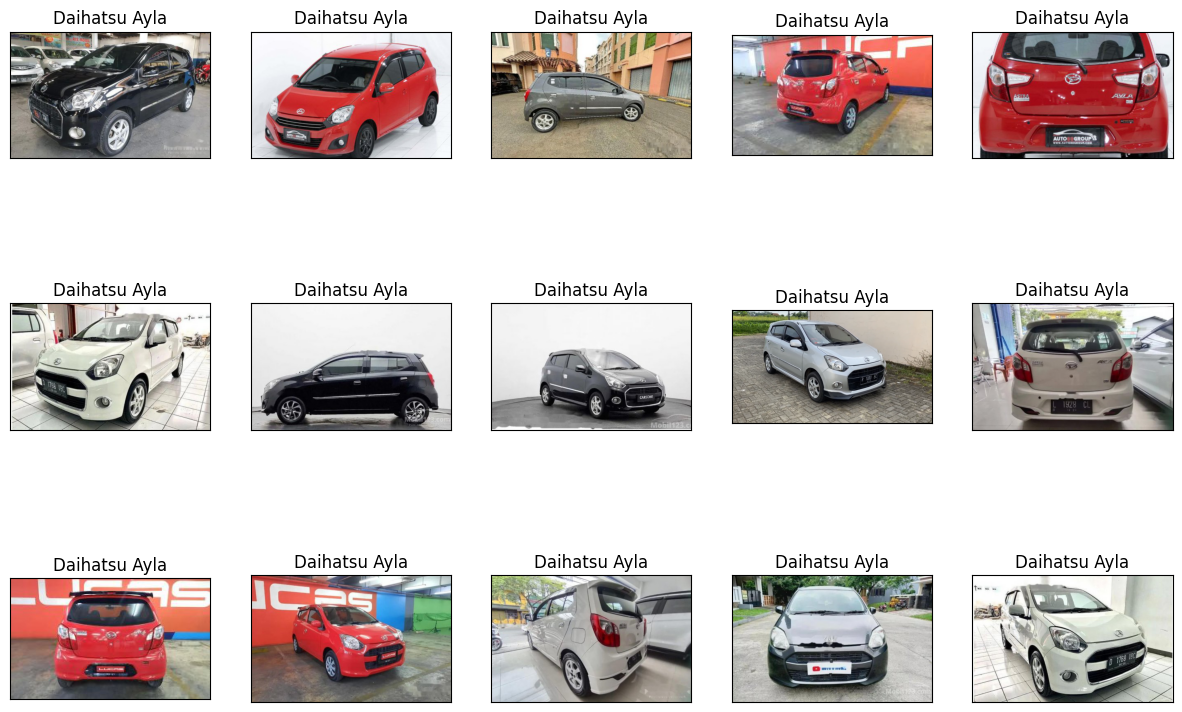

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [10]:
df.label.value_counts()

Honda Brio Satya    68
Daihatsu Ayla       67
Toyota Agya         48
Name: label, dtype: int64

In [11]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Honda Brio Satya    68
Daihatsu Ayla       67
Toyota Agya         48
Name: label, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [14]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (102, 2)
Shape of test data (55, 2)
Shape of validation data (26, 2)


In [15]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 102 validated image filenames belonging to 3 classes.
Found 55 validated image filenames belonging to 3 classes.
Found 26 validated image filenames belonging to 3 classes.


In [50]:
input_shape = (200, 200, 3)

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 99, 99, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 23, 23, 32)      

In [52]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 32, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
4/4 [==============================] - 17s 4s/step - loss: 1.1694 - accuracy: 0.3333 - val_loss: 1.0933 - val_accuracy: 0.3462
Epoch 2/100
4/4 [==============================] - 15s 3s/step - loss: 1.1479 - accuracy: 0.2745 - val_loss: 1.0909 - val_accuracy: 0.5385
Epoch 3/100
4/4 [==============================] - 16s 5s/step - loss: 1.0976 - accuracy: 0.3039 - val_loss: 1.0676 - val_accuracy: 0.5385
Epoch 4/100
4/4 [==============================] - 14s 4s/step - loss: 1.0993 - accuracy: 0.3529 - val_loss: 1.0714 - val_accuracy: 0.5385
Epoch 5/100
4/4 [==============================] - 14s 3s/step - loss: 1.0958 - accuracy: 0.4118 - val_loss: 1.0680 - val_accuracy: 0.5385
Epoch 6/100
4/4 [==============================] - 16s 4s/step - loss: 1.0878 - accuracy: 0.3529 - val_loss: 1.0437 - val_accuracy: 0.5385
Epoch 7/100
4/4 [==============================] - 14s 4s/step - loss: 1.0948 - accuracy: 0.3529 - val_loss: 1.0376 - val_accuracy: 0.5385
Epoch 8/100
4/4 [==========

In [53]:
model.save('model-1.h5')

In [54]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

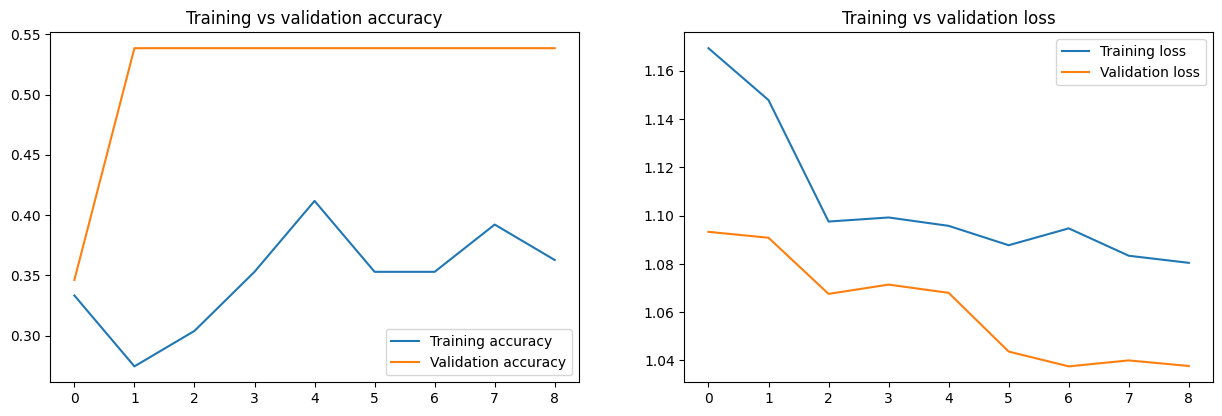

In [55]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [56]:
pred = model.predict(test)

2/2 [==============================] - 3s 611ms/step


In [57]:
pred = np.argmax(pred, axis=1)

In [58]:
labels = train.class_indices

In [59]:
labels

{'Daihatsu Ayla': 0, 'Honda Brio Satya': 1, 'Toyota Agya': 2}

In [60]:
labels = dict((v,k) for k, v in labels.items())

In [61]:
labels

{0: 'Daihatsu Ayla', 1: 'Honda Brio Satya', 2: 'Toyota Agya'}

In [62]:
y_pred = [labels[k] for k in pred]

In [63]:
print(classification_report(x_test.label, y_pred))

                  precision    recall  f1-score   support

   Daihatsu Ayla       0.35      0.88      0.50        17
Honda Brio Satya       0.29      0.08      0.12        25
     Toyota Agya       0.40      0.15      0.22        13

        accuracy                           0.35        55
       macro avg       0.34      0.37      0.28        55
    weighted avg       0.33      0.35      0.26        55



In [64]:
print(confusion_matrix(x_test.label, y_pred))

[[15  2  0]
 [20  2  3]
 [ 8  3  2]]


In [65]:
test_accuracy = model.evaluate(test)[1]

2/2 [==============================] - 4s 931ms/step - loss: 1.0467 - accuracy: 0.3818
